### Import required library

In [1]:
from src import Distortion, Perspective, Thresholding, Line, plot_lines
from glob import glob
import os
import matplotlib.image as mpeg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np

### Function to plot images

In [2]:
def plot_images(images: [], titles: []):
    cols = len(titles)
    if cols == 0:
        raise Exception("'titles' length must be greater then zero")
    rows = int(len(images)/cols)
    axes=[]
    fig=plt.figure()
    for a in range(int(rows*cols)):
        axes.append( fig.add_subplot(rows, cols, a+1) )
        subplot_title=(titles[a % cols])
        axes[-1].set_title(subplot_title)
        plt.imshow(images[a])
    fig.tight_layout()
    plt.show()

### Distortion caluculation
Calculated distortion using **camera_cal** chess board image

In [3]:
cal_image_path = os.path.join('./', 'camera_cal', '*.jpg')
cal_image = glob(cal_image_path)
distortion = Distortion(nx=9, ny=6)
distortion.calculate(cal_image)

### Apply calibration on chess board

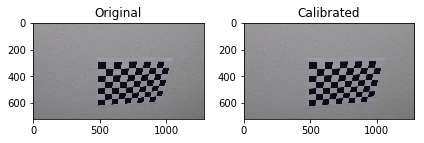

In [4]:
cal_test_image_path = os.path.join('./', 'camera_cal', 'calibration10.jpg')
cal_test_image_out_path = os.path.join('./', 'output_images', 'calibration10.jpg')
cal_test_input_image = mpeg.imread(cal_test_image_path)
cal_test_img_out = distortion.fix(cal_test_input_image)
plot_images(images=[cal_test_input_image, cal_test_img_out], titles=['Original', 'Calibrated'])
plt.imsave(cal_test_image_out_path, cal_test_img_out)


### Calibartion of test images

In [5]:
def cal_test_image():
    test_images = glob(os.path.join('./', 'test_images', '*.jpg'))
    for image_url in test_images:
        image = mpeg.imread(image_url)
        fixed_image = distortion.fix(image)
        plt.imsave(os.path.join('./', 'output_images', 'calibrated_{}'.format(image_url.split('/')[-1])), fixed_image)
cal_test_image()

### Thrasolding params

In [6]:
th_sobelx, th_sobely, th_mag, th_dir = (35, 100), (30, 255), (50, 100), (0.7, 1.3)
th_s = (85, 255)

### Apply each transformation on image

In [10]:
def test_image():
    perspective = Perspective()
    line = Line()
    test_images = glob(os.path.join('./', 'test_images', '*.jpg'))
    for image_url in test_images:
        image = mpeg.imread(image_url)
        cal = distortion.fix(image)
        thresholding = Thresholding(cal)
        grad_binary = thresholding.gradient_thresh(th_sobelx, th_sobely, th_mag, th_dir)
        hsl_binary = thresholding.color_thresh(th_s)
        
        result = thresholding.result(grad_binary, hsl_binary) * 255
        plt.imsave(os.path.join('./', 'output_images', 'threshold_{}'.format(image_url.split('/')[-1])), np.dstack((result, result, result)))
        
        warped = perspective.transform(result)
        plt.imsave(os.path.join('./', 'output_images', 'bird_eye_{}'.format(image_url.split('/')[-1])), warped)
        
        leftx, lefty, rightx, righty, left_fit, right_fit, img = line.poly_sliding_window(warped)
        
        plt.imsave(os.path.join('./', 'output_images', 'sliding_window_{}'.format(image_url.split('/')[-1])), img)
        
        left_curve, right_curve = line.calculate_curve(leftx, lefty, rightx, righty)
        vehicle_offset = line.calc_vehicle_offset(cal, left_fit, right_fit)
        result = plot_lines(cal, left_fit, right_fit, perspective.m_inv, left_curve, right_curve, vehicle_offset)
        plt.imsave(os.path.join('./', 'output_images', 'final_{}'.format(image_url.split('/')[-1])), result)    
test_image()

### Apply lane detection on video

In [11]:
white_output = os.path.join('./', 'output_videos','binary_project_video.mp4')
perspective = Perspective()
line = Line()
def process_video_image(image):
    cal = distortion.fix(image)
    thresholding = Thresholding(cal)
    grad_binary = thresholding.gradient_thresh(th_sobelx, th_sobely, th_mag, th_dir)
    hsl_binary = thresholding.color_thresh(th_s)
    result = thresholding.result(grad_binary, hsl_binary)*255
    warped = perspective.transform(result)
    leftx, lefty, rightx, righty, left_fit, right_fit, img = line.result(warped)
    left_curve, right_curve = line.calculate_curve(leftx, lefty, rightx, righty)
    vehicle_offset = line.calc_vehicle_offset(cal, left_fit, right_fit)
    return plot_lines(cal, left_fit, right_fit, perspective.m_inv, left_curve, right_curve, vehicle_offset)
def binary_video():
    clip1 = VideoFileClip(os.path.join('./', 'project_video.mp4'))
    white_clip = clip1.fl_image(process_video_image)
    white_clip.write_videofile(white_output, audio=False)
binary_video()

[MoviePy] >>>> Building video ./output_videos/binary_project_video.mp4
[MoviePy] Writing video ./output_videos/binary_project_video.mp4


100%|█████████▉| 1260/1261 [28:31<00:01,  1.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/binary_project_video.mp4 



In [12]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(white_output))
